In [1]:
import edward as ed
from edward.models import Poisson,Gamma
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import helper_func
import math
import models
import scipy.special as sp
from scipy.misc import logsumexp
import gc

In [2]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

In [3]:
dataset = 'movielens'  #bibx,biby,movielens
full_X,y,test_mask = helper_func.load_data(dataset)
y = full_X
result_folder = "dual_bibtex"
metric = 'mae_nz_all'
tot = 100
tot += 1
ndcg = []
test_every = 20;
no_sample = 100
score = []

In [4]:
K = 50
users = y.shape[0]
items = y.shape[1]
param = models.hpf(users,items)
a = a_c = c = c_c = 0.3
b_c = d_c = 1.0      

In [5]:
kappa_shp =  np.random.uniform(low=0.1,size=users)
kappa_rte = np.random.uniform(low=0.1,size=users)
tau_shp = np.random.uniform(low=0.1,size=items)
tau_rte = np.random.uniform(low=0.1,size=items)
phi = np.zeros([users,items,K])
gam_shp = np.random.uniform(low=0.1,size=[users,K])
gam_rte = np.random.uniform(low=0.1,size=[users,K])
lam_shp = np.random.uniform(low=0.1,size=[items,K])
lam_rte = np.random.uniform(low=0.1,size=[items,K])
non_zero_indices = helper_func.non_zero_entries(y)    

In [6]:
for u in range(0,users):
    kappa_shp[u] = a_c + K*a
for i in range(0,items):
    tau_shp[i] = c_c + K*c
    
for ite in range(0,tot):

    if ite%1==0:
        print(ite)
       
    for ui in non_zero_indices:
        u = ui[0]
        i = ui[1]
        phi[u,i,:]= sp.digamma(gam_shp[u,:])-np.log(gam_rte[u,:])+sp.digamma(lam_shp[i,:])-np.log(lam_rte[i,:])
        log_norm = logsumexp(phi[u,i,:])
        phi[u,i,:] = np.exp(phi[u,i,:]-log_norm)
        
    for u in range(0,users):
        for k in range(0,K):
            gam_shp[u,k] = a + np.inner(y[u,:],phi[u,:,k])
            gam_rte[u,k] = (kappa_shp[u]/kappa_rte[u]) + np.sum(lam_shp[:,k]/lam_rte[:,k])
        kappa_rte[u] = (a_c/b_c) + np.sum(gam_shp[u,:]/gam_rte[u,:])
    
    for i in range(0,items):
        for k in range(0,K):
            lam_shp[i,k] = c + np.inner(y[:,i],phi[:,i,k])
            lam_rte[i,k] = (tau_shp[i]/tau_rte[i]) + np.sum(gam_shp[:,k]/gam_rte[:,k])
        tau_rte[i] = (c_c/d_c) + np.sum(lam_shp[i,:]/lam_rte[i,:])
    
    if ite%test_every == 0:
        q_theta = Gamma(gam_shp,gam_rte)
        q_beta = Gamma(np.transpose(lam_shp),np.transpose(lam_rte))
        beta_sample = q_beta.sample(no_sample).eval()
        theta_sample = q_theta.sample(no_sample).eval()
        score.append(helper_func.check(param,theta_sample,beta_sample,test_mask,full_X,metric=metric))
        gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


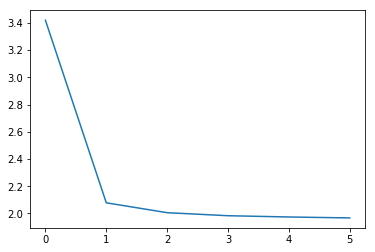

1.9669938338


In [7]:
plt.plot(score)
plt.show()
print min(score)